## 🧠 Modélisation : Prédire le diabète à partir des données cliniques

Après avoir nettoyé et normalisé les données, nous passons à la phase de modélisation.  
L’objectif est de tester plusieurs algorithmes de classification et d’évaluer leur performance de manière rigoureuse.

### 🎯 Stratégie d’évaluation :

- Le jeu de données est séparé en **60% pour l'entraînement**, **20% pour la validation**, et **20% pour le test final**.
- La **validation croisée** est réalisée uniquement sur les **80% (train + validation)** pour affiner les modèles et détecter le surapprentissage.
- La **précision (accuracy)** sera notre métrique principale, mais nous analyserons également :
  - le **rappel (recall)**,  
  - la **précision**,  
  - le **F1-score**,  
  - et la **matrice de confusion** pour une évaluation plus fine.


In [20]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Charger les données
df = pd.read_csv('../data/data_normalized.csv')

# 2. Séparer les features et la cible
X = df.drop(columns=['diabetes'])
y = df['diabetes']

# 3. Première séparation : 80% (train + val) et 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Deuxième séparation : 75% train et 25% val sur les 80% restants → soit 60/20/20
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

# Vérification des proportions
print(f"Train: {len(X_train)}\nValidation: {len(X_val)}\nTest: {len(X_test)}")

df.head()

Train: 46509
Validation: 15503
Test: 15503


,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_history_encoded
0,0,1.733218,0,1,-0.286210,1.165576,0.067234,0,0.0
1,0,0.585572,0,0,0.027889,1.165576,-1.435944,0,3.0
2,1,-0.562075,0,0,0.027889,0.082439,0.518188,0,0.0
3,0,-0.208953,0,0,-0.542798,-0.760001,0.443029,0,2.0
4,1,1.556657,1,1,-1.030905,-1.000698,0.443029,0,2.0


In [21]:
# Vérifier les valeurs manquantes dans les données
print(df.isna().sum())


gender                     0
age                        0
hypertension               0
heart_disease              0
bmi                        0
HbA1c_level                0
blood_glucose_level        0
diabetes                   0
smoking_history_encoded    0
dtype: int64


=== Validation croisée (5-fold) sur les données d'entraînement ===

Random Forest: Accuracy moyenne = 0.967 (+/- 0.001)
Logistic Regression: Accuracy moyenne = 0.956 (+/- 0.002)
SVM: Accuracy moyenne = 0.960 (+/- 0.001)

=== Évaluation finale sur le set de test ===


📌 Modèle : Random Forest
              precision    recall  f1-score   support

           0      0.970     0.996     0.983     14376
           1      0.930     0.603     0.732      1127

    accuracy                          0.968     15503
   macro avg      0.950     0.800     0.857     15503
weighted avg      0.967     0.968     0.965     15503



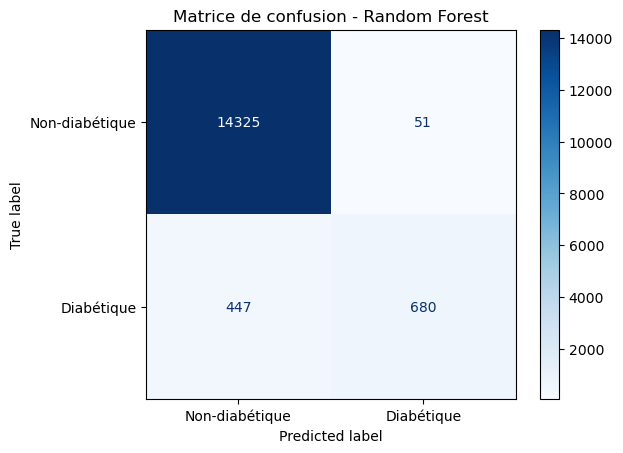


📌 Modèle : Logistic Regression
              precision    recall  f1-score   support

           0      0.965     0.990     0.977     14376
           1      0.802     0.536     0.643      1127

    accuracy                          0.957     15503
   macro avg      0.883     0.763     0.810     15503
weighted avg      0.953     0.957     0.953     15503



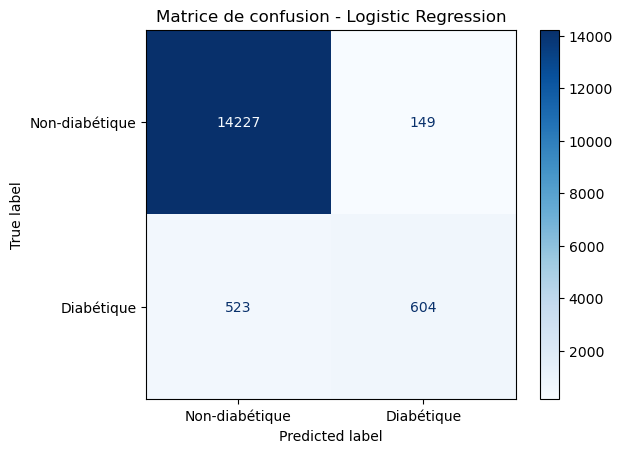


📌 Modèle : SVM
              precision    recall  f1-score   support

           0      0.962     1.000     0.980     14376
           1      0.991     0.490     0.656      1127

    accuracy                          0.963     15503
   macro avg      0.976     0.745     0.818     15503
weighted avg      0.964     0.963     0.957     15503



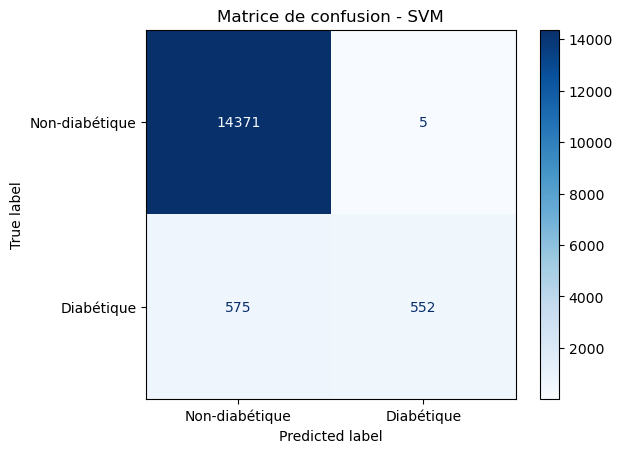

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay


# 📦 Définir les modèles à tester
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

# 🔄 Validation croisée sur l’ensemble d'entraînement (X_train + y_train)
print("=== Validation croisée (5-fold) sur les données d'entraînement ===\n")
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name}: Accuracy moyenne = {scores.mean():.3f} (+/- {scores.std():.3f})")

# 📊 Évaluation finale sur le set de test
print("\n=== Évaluation finale sur le set de test ===\n")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n📌 Modèle : {name}")
    print(classification_report(y_test, y_pred, digits=3))

    # Affichage de la matrice de confusion
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Non-diabétique", "Diabétique"], cmap="Blues")
    plt.title(f"Matrice de confusion - {name}")
    plt.show()


## 🔄 1. Résultats de la validation croisée (5-fold sur les données d'entraînement)

| Modèle               | Accuracy Moyenne | Écart-type |
|----------------------|------------------|------------|
| Random Forest        | 0.967            | ±0.001     |
| Logistic Regression  | 0.956            | ±0.002     |
| SVM                  | 0.960            | ±0.001     |

**Interprétation :**
- Tous les modèles sont très performants en validation croisée, avec des scores d’accuracy supérieurs à 95%.
- **Random Forest** se distingue légèrement en tête avec une moyenne de **96.7%**, mais les écarts sont faibles.
- La **faible variance** (écart-type entre 0.001 et 0.002) montre une **bonne stabilité** des modèles sur les différentes folds.

---

## 📊 2. Résultats sur le jeu de test

### 📌 Random Forest

| Classe             | Précision | Rappel | F1-score | Support |
|--------------------|-----------|--------|----------|---------|
| 0 (Non-diabétique) | 0.970     | 0.996  | 0.983    | 14376   |
| 1 (Diabétique)     | 0.930     | 0.603  | 0.732    | 1127    |

- **Accuracy globale** : **96.8%**
- **Points forts** : Excellent à détecter les non-diabétiques avec très peu de faux positifs.
- **Point faible** : Le rappel pour la classe diabétique est faible (**0.603**) → **40% des diabétiques réels sont manqués**.
- **Utilité** : Bon choix si l'on veut éviter les fausses alertes, mais pas idéal si **rater un diabétique est critique**.

---

### 📌 Logistic Regression

| Classe             | Précision | Rappel | F1-score | Support |
|--------------------|-----------|--------|----------|---------|
| 0 (Non-diabétique) | 0.965     | 0.990  | 0.977    | 14376   |
| 1 (Diabétique)     | 0.802     | 0.536  | 0.643    | 1127    |

- **Accuracy globale** : **95.7%**
- Moins performant que Random Forest.
- Précision plus faible pour les diabétiques (**0.802**) et un rappel encore plus bas (**0.536**).
- **Utilité** : Moins de faux positifs que SVM, mais **manque encore plus de vrais cas**.

---

### 📌 SVM

| Classe             | Précision | Rappel | F1-score | Support |
|--------------------|-----------|--------|----------|---------|
| 0 (Non-diabétique) | 0.962     | 1.000  | 0.980    | 14376   |
| 1 (Diabétique)     | 0.991     | 0.490  | 0.656    | 1127    |

- **Accuracy globale** : **96.3%**
- Très haute précision pour les diabétiques (**0.991**) → très peu de faux positifs.
- **Mais rappel très bas** (**0.490**) → **plus de la moitié des diabétiques sont ratés**.
- **Utilité** : Excellent pour éviter les fausses alertes, mais **risque élevé de faux négatifs**.

---

## ⚖️ Comparaison générale des modèles (Classe 1 - Diabétique)

| Modèle               | Précision | Rappel | F1-score |
|----------------------|-----------|--------|----------|
| Random Forest        | 0.930     | 0.603  | 0.732    |
| Logistic Regression  | 0.802     | 0.536  | 0.643    |
| SVM                  | 0.991     | 0.490  | 0.656    |


## 🚀 Essai du modèle XGBoost

Après avoir évalué plusieurs modèles classiques (Random Forest, Régression Logistique, SVM), nous allons maintenant tester **XGBoost**, un algorithme de gradient boosting réputé pour ses excellentes performances sur des données tabulaires.

L'objectif est de voir si XGBoost permet d'améliorer le **rappel** sur la classe minoritaire (les diabétiques), tout en maintenant une bonne précision globale.


=== Validation croisée (5-fold) sur les données d'entraînement ===

XGBoost: Accuracy moyenne = 0.968 (+/- 0.002)

=== Évaluation finale sur le set de test ===


📌 Modèle : XGBoost
              precision    recall  f1-score   support

           0      0.972     0.995     0.983     14376
           1      0.912     0.628     0.744      1127

    accuracy                          0.969     15503
   macro avg      0.942     0.812     0.864     15503
weighted avg      0.967     0.969     0.966     15503



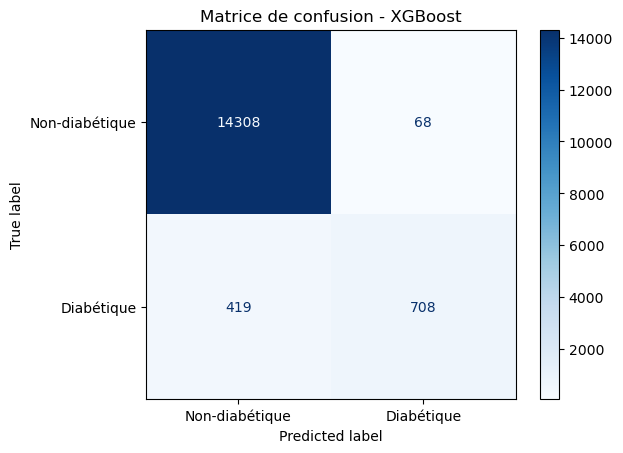

In [22]:
from xgboost import XGBClassifier

# 📦 Ajouter XGBoost au dictionnaire des modèles
models = {
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}

# 🔄 Validation croisée sur l’ensemble d'entraînement (X_train + y_train)
print("=== Validation croisée (5-fold) sur les données d'entraînement ===\n")
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name}: Accuracy moyenne = {scores.mean():.3f} (+/- {scores.std():.3f})")

# 📊 Évaluation finale sur le set de test
print("\n=== Évaluation finale sur le set de test ===\n")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n📌 Modèle : {name}")
    print(classification_report(y_test, y_pred, digits=3))

    # Affichage de la matrice de confusion
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        display_labels=["Non-diabétique", "Diabétique"],
        cmap="Blues"
    )
    plt.title(f"Matrice de confusion - {name}")
    plt.show()


## 📌 Modèle : XGBoost

### 🔄 Résultats de la validation croisée (5-fold sur l’ensemble d'entraînement)

| Modèle    | Accuracy Moyenne | Écart-type |
|-----------|------------------|------------|
| XGBoost   | 0.968            | 0.002     |

 **Interprétation** :
- Très bonnes performances sur l’ensemble d entraînement.
- Faible écart-type : stabilité du modèle sur les différentes folds.

---

### 📊 Résultats sur le jeu de test

| Classe             | Précision | Rappel | F1-score | Support |
|--------------------|-----------|--------|----------|---------|
| 0 (Non-diabétique) | 0.972     | 0.995  | 0.983    | 14 376  |
| 1 (Diabétique)     | 0.912     | 0.628  | 0.744    | 1 127   |

- **Accuracy globale** : `96.9%`
- **Macro avg (moyenne non pondérée)** : F1 = `0.864`
- **Weighted avg (moyenne pondérée)** : F1 = `0.966`

---

###  Interprétation
- **Classe 0 (Non-diabétique)** :
  - Très bien détectée (haut rappel), très peu de faux positifs.
- **Classe 1 (Diabétique)** :
  - Bonne précision (0.912) → la majorité des prédictions 'diabétique sont correctes.
  - Rappel modéré (0.628) → environ 63% des diabétiques sont correctement identifiés.

---

### ⚖️ Comparaison avec les autres modèles (Classe 1 - Diabétique)

| Modèle              | Précision | Rappel | F1-score |
|---------------------|-----------|--------|----------|
| **XGBoost**         | **0.912** | **0.628** | **0.744** |
| Random Forest        | 0.930     | 0.603  | 0.732    |
| Logistic Regression  | 0.802     | 0.536  | 0.643    |
| SVM                  | 0.991     | 0.490  | 0.656    |

---

### 🏁 Conclusion
- **XGBoost** fournit le **meilleur compromis entre précision et rappel** pour la classe des diabétiques.
- Modèle recommandé si l’objectif est de **maximiser la détection des diabétiques tout en maintenant peu de faux positifs**.


Meilleurs paramètres: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.8}


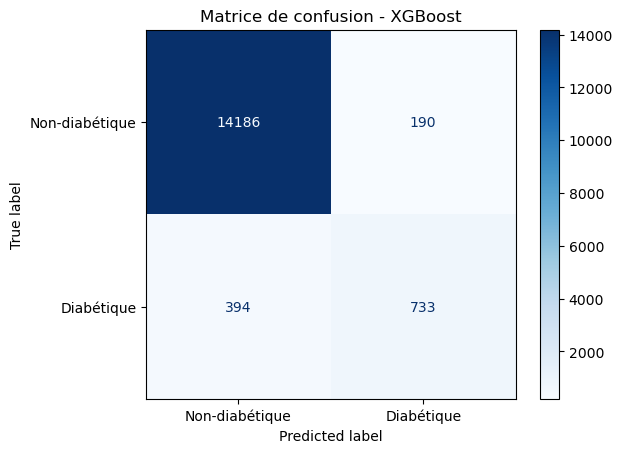


=== Évaluation finale avec seuil ajusté ===
              precision    recall  f1-score   support

           0      0.977     0.972     0.974     14376
           1      0.663     0.713     0.687      1127

    accuracy                          0.953     15503
   macro avg      0.820     0.842     0.831     15503
weighted avg      0.954     0.953     0.954     15503



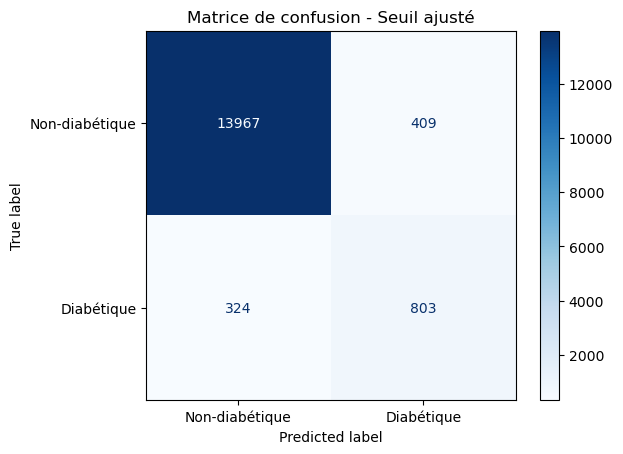

In [23]:

# Appliquer SMOTE pour rééquilibrer les classes sur l'ensemble d'entraînement
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# Définir le modèle XGBoost
xgb_model = XGBClassifier( eval_metric='logloss', random_state=42)

# GridSearchCV pour ajuster les hyperparamètres du modèle
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid,
                           scoring='f1',  # Maximiser F1-score pour la classe 1
                           cv=3, n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Afficher les meilleurs paramètres trouvés
print(f"Meilleurs paramètres: {grid_search.best_params_}")

# Utiliser le modèle avec les meilleurs paramètres
best_model = grid_search.best_estimator_

# Évaluation finale sur le set de test
y_pred = best_model.predict(X_test)


# Affichage de la matrice de confusion
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=["Non-diabétique", "Diabétique"],
    cmap="Blues"
)
plt.title("Matrice de confusion - XGBoost")
plt.show()

# Ajuster le seuil de classification pour améliorer le rappel (si nécessaire)
# Prédire les probabilités
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

# Choisir un seuil pour maximiser le rappel
threshold = 0.3  # Exemple de seuil
y_pred_adjusted = (y_pred_prob > threshold).astype(int)

# Évaluation avec le seuil ajusté
print("\n=== Évaluation finale avec seuil ajusté ===")
print(classification_report(y_test, y_pred_adjusted, digits=3))

# Affichage de la matrice de confusion après ajustement du seuil
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_adjusted,
    display_labels=["Non-diabétique", "Diabétique"],
    cmap="Blues"
)
plt.title("Matrice de confusion - Seuil ajusté")
plt.show()

### Maximiser la détection des diabétiques

Pour détecter le plus de diabétiques possible, même au détriment de la précision, plusieurs stratégies ont été mises en place :

- **SMOTE** : Rééquilibrage des classes dans l’ensemble d'entraînement pour mieux identifier les diabétiques.
- **XGBoost** : Optimisation du modèle avec GridSearchCV pour maximiser le F1-score de la classe diabétique.
- **Ajustement du seuil** : Réduction du seuil de classification pour augmenter le rappel des diabétiques, même si la précision diminue légèrement.

### Résultat
Après ajustement du seuil, le rappel des diabétiques a augmenté à **0.713**, ce qui permet de réduire les faux négatifs, au prix d'une légère baisse de précision.

### Conclusion
Cette approche est idéale lorsqu'il est essentiel de **ne pas manquer un diabétique**, même si cela entraîne un léger compromis sur la précision.
